<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/GradCam_Lib_Simplified_Vs_Single_Pass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Image and Trained Model

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# id = ['18A9mAt9r4CoXLeoCK2muPNvIEqVKvOaw']
id = ['1pZgspfWi1Mh8sqV_lbJLQTuFZyhnTPlA']
downloaded = drive.CreateFile({'id':id[0]}) 
downloaded.GetContentFile('localization_2.zip')
!unzip localization_2.zip

Archive:  localization_2.zip
  inflating: localization/001202.png  
  inflating: localization/001203.png  
  inflating: localization/1_frame132.png  
  inflating: localization/1_frame146.png  
  inflating: localization/16_frame119.png  
  inflating: localization/16_frame122.png  
  inflating: localization/5_frame078.png  
  inflating: localization/5_frame118.png  
  inflating: localization/combine_miccai18_ResNet50_256,320_170_best_checkpoint.pth.tar  
  inflating: localization/raw_image.png  


Fix seed to get result reproducibility

In [2]:
import random
import torch
import numpy as np
import os

def seed_everything(seed=42):
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed_everything()

**Demo**

Load model checkpoint

In [3]:
import torch.nn as nn
from torch.nn import DataParallel
from torchvision import models

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 11)
model = DataParallel(model)
# model.to(device)
result_filename = 'combine_miccai18_ResNet50_256,320_170'
best_checkpoint_path = 'localization/' + result_filename + '_best_checkpoint.pth.tar'
checkpoint      = torch.load(best_checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model = model.module
model.cuda();
model.eval();

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Simplified Lib code in one Cell:

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


prediction of model: [1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.]
predicted class: ['bipolar_forceps', 'monopolar_curved_scissors', 'suction', 'tissue']
grads, weights.shape, activations.shape, weighted_activations.shape (1, 2048, 8, 10) (1, 2048) (1, 2048, 8, 10) (1, 2048, 8, 10)
grads, weights.shape, activations.shape, weighted_activations.shape (1, 2048, 8, 10) (1, 2048) (1, 2048, 8, 10) (1, 2048, 8, 10)
grads, weights.shape, activations.shape, weighted_activations.shape (1, 2048, 8, 10) (1, 2048) (1, 2048, 8, 10) (1, 2048, 8, 10)
grads, weights.shape, activations.shape, weighted_activations.shape (1, 2048, 8, 10) (1, 2048) (1, 2048, 8, 10) (1, 2048, 8, 10)
grads, weights.shape, activations.shape, weighted_activations.shape (1, 2048, 8, 10) (1, 2048) (1, 2048, 8, 10) (1, 2048, 8, 10)
grads, weights.shape, activations.shape, weighted_activations.shape (1, 2048, 8, 10) (1, 2048) (1, 2048, 8, 10) (1, 2048, 8, 10)
grads, weights.shape, activations.shape, weighted_activations.shape (1, 2048, 8, 10

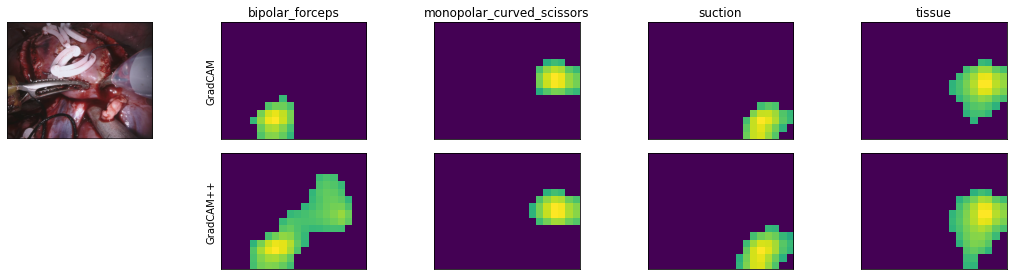

In [11]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms as tf
from PIL import Image
import matplotlib.pyplot as plt


class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """
    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(
                    self.save_activation))
            # Backward compitability with older pytorch versions:
            if hasattr(target_layer, 'register_full_backward_hook'):
                self.handles.append(
                    target_layer.register_full_backward_hook(
                        self.save_gradient))
            else:
                self.handles.append(
                    target_layer.register_backward_hook(
                        self.save_gradient))
    
    def save_activation(self, module, input, output):
        activation = output  
        # print(activation.size())      # torch.Size([81, 2048, 4, 7])
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())  

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        grad = grad_output[0]
        # print(grad.size())              # torch.Size([81, 2048, 4, 7])
        if self.reshape_transform is not None:
            grad = self.reshape_transform(grad)
        self.gradients = [grad.cpu().detach()] + self.gradients
        # print(len(self.gradients))   # 1

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()

class BaseCAM:
    def __init__(self,
                 model,
                 target_layers,
                 use_cuda=False,
                 reshape_transform=None,
                 compute_input_gradient=False,
                 uses_gradients=True):
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    def get_loss(self, output, target_category):
        loss = 0
        # model output is the loss
        for i in range(len(target_category)):
            # output[i, target_category[i]]: output at particular data and particular class
            loss = loss + output[i, target_category[i]]
        return loss
    
    def scale_cam_image(self, cam, target_size=None):
        result = []
        for img in cam:
            img = img - np.min(img) 
            img = img / (1e-7 + np.max(img))
            if target_size is not None:
                img = cv2.resize(img, target_size)
            result.append(img)
        result = np.float32(result)   # result.shape: (81, 120, 210) (bs,h,w)
        return result

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth=False):
        weights = self.get_cam_weights(input_tensor, target_layer, target_category, activations, grads)  # shape of weights: (81, 2048)
        weighted_activations = weights[:, :, None, None] * activations      # shape of weighted_activations: 81, 2048, 4, 7

        print('grads, weights.shape, activations.shape, weighted_activations.shape',grads.shape, weights.shape, activations.shape, weighted_activations.shape)
        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)  # shape of cam: 81, 4, 7 

        return cam

    def compute_cam_per_layer(
            self,
            input_tensor,
            target_category,
            eigen_smooth,
            target_size):
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        if target_size == None:
            target_size = self.get_target_width_height(input_tensor)  # (w, h): (210, 120)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer

        for target_layer, layer_activations, layer_grads in \
                zip(self.target_layers, activations_list, grads_list):
            cam = self.get_cam_image(input_tensor,          # print(cam.shape): (81, 4, 7)  cam=>numpy array
                                     target_layer,
                                     target_category,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)

            cam[cam<0.0]=0 # works like mute the min-max scale in the function of scale_cam_image  # make those <0 = 0 range[0,1.7495756]
            scaled = self.scale_cam_image(cam, target_size)  # from size (81, 4, 7) to (81, 120, 210) , value ranged from [0,1.7495756] to [0.0 0.99988055]
            cam_per_target_layer.append(scaled[:, None, :])  # (81, 1, 120, 210)  (bs,num_target_layer,h,w)
        return cam_per_target_layer


    def forward(self, input_tensor, target_category=None, eigen_smooth=False, target_size=None):
        if self.cuda:
            input_tensor = input_tensor.cuda()

        output = self.activations_and_grads(input_tensor)
        output_sigmoid = torch.sigmoid(output)
        # print(input_tensor.shape)       # torch.Size([81, 3, 120, 210])
        # print(output.shape)             # torch.Size([81, 7])
        if isinstance(target_category, int):        
            target_category = [target_category] * input_tensor.size(0) 

        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy(), axis=-1)
        else:
            # assert: tests if a condition is true
            assert(len(target_category) == input_tensor.size(0))

        if self.uses_gradients:
            self.model.zero_grad()
            loss = self.get_loss(output, target_category)
            loss.backward(retain_graph=True)
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   target_category,
                                                   eigen_smooth, 
                                                   target_size)
        return output_sigmoid, np.stack(cam_per_layer).squeeze()
        
    def __call__(self,
                 input_tensor,
                 target_category=None,
                 aug_smooth=False,
                 eigen_smooth=False,
                 target_size=None):
        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, target_category, eigen_smooth, target_size)

        return self.forward(input_tensor,
                            target_category, eigen_smooth, target_size)

class GradCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(
            GradCAM,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)
    
    def get_cam_weights(self,
                        input_tensor,
                        target_layer,
                        target_category,
                        activations,
                        grads):     
        return np.mean(grads, axis=(2, 3))  # shape of grads: 81,2048,4,7

class GradCAMPlusPlus(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(GradCAMPlusPlus, self).__init__(model, target_layers, use_cuda,
                                              reshape_transform)

    def get_cam_weights(self,
                        input_tensor,
                        target_layers,
                        target_category,
                        activations,
                        grads):
        grads_power_2 = grads**2
        grads_power_3 = grads_power_2 * grads
        # Equation 19 in https://arxiv.org/abs/1710.11063
        sum_activations = np.sum(activations, axis=(2, 3))
        eps = 0.000001
        aij = grads_power_2 / (2 * grads_power_2 +
                               sum_activations[:, :, None, None] * grads_power_3 + eps)
        # Now bring back the ReLU from eq.7 in the paper,
        # And zero out aijs where the activations are 0
        aij = np.where(grads != 0, aij, 0)

        weights = np.maximum(grads, 0) * aij
        weights = np.sum(weights, axis=(2, 3))
        return weights        #  (1, 2048)


image_name = "localization/1_frame146.png"
classes = ['bipolar_forceps', 'prograsp_forceps', 'large_needle_driver', 'monopolar_curved_scissors', 'ultrasound_probe', 'suction', 'clip_applier', 'stapler', 'hook', 'specimen_bag', 'tissue']
image = Image.open(image_name).convert('RGB')
transforms = tf.Compose([tf.Resize((256,320)), 
                        tf.ToTensor(),
                        tf.Normalize([0.4084945, 0.25513682, 0.25353566], [0.22662906, 0.20201652, 0.1962526 ])])
inputs = transforms(image).cuda()
pred_thr = 0.5
heatmap_thr = 0.6
pool_size = [512,1,1]

outputs_tool = model.forward(inputs[None])
pred = torch.sigmoid(outputs_tool[0]).detach().cpu().numpy()
score = np.array(pred>pred_thr, dtype=float)
print('prediction of model:',score)

indices = [i for i, x in enumerate(score) if x == 1]
pred_class = []
for i in range(len(indices)):
  pred_class.append(classes[indices[i]])
print('predicted class:', pred_class)
model.eval()
target_layers = [model.layer4[-1]]

##GradCam
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

heatmap_all = []
for cls in range (11):
    if score[cls]:
        output, heat_map = cam(input_tensor=inputs[None].cuda(), target_category=cls, target_size=(20, 16))  #grayscale_cam: (16, 20) (8, 10)
        heatmap_all.append(heat_map)
        heat_map = torch.from_numpy(heat_map)       # [1,16,20] 
    

heatmap_all = np.stack(heatmap_all).squeeze()
heatmap_all[heatmap_all<heatmap_thr] = 0

##GradCam++
campp = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=False)

heatmap_all_plusplus = []
for cls in range (11):
    if score[cls]:
        output, heat_map = campp(input_tensor=inputs[None].cuda(), target_category=cls, target_size=(20, 16))  #grayscale_cam: (16, 20) (8, 10)
        heatmap_all_plusplus.append(heat_map)
        heat_map = torch.from_numpy(heat_map)       # [1,16,20] 
    

heatmap_all_plusplus = np.stack(heatmap_all_plusplus).squeeze()
heatmap_all_plusplus[heatmap_all_plusplus<heatmap_thr] = 0

##Visualization
x = len(heatmap_all) + 1
figure = plt.figure(figsize=(15, 4))
figure.add_subplot(2,x,1)
plt.axis("off")
plt.imshow(image)
for j in range(1,x):
    figure.add_subplot(2,x,j+1)
    # plt.axis("off")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(heatmap_all[j-1])
    if j == 1:
      plt.ylabel('GradCAM')
    plt.title(pred_class[j-1])

for k in range(1,x):
    figure.add_subplot(2,x,x+k+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(heatmap_all_plusplus[k-1])
    if k == 1:
      plt.ylabel('GradCAM++')
plt.subplots_adjust(wspace=0.0, 
                    hspace=0)
figure.tight_layout()
plt.show()

# Single Pass GradCAM

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get th

Probability: [0.999, 0.33, 0.016, 0.873, 0.002, 0.996, 0.006, 0.054, 0.0, 0.0, 1.0]
Labels: [0, 3, 5, 10] Predictions: [0, 3, 5, 10]
pooled_gradients, activations, gradients: torch.Size([1, 512]) torch.Size([1, 512, 8, 10]) torch.Size([1, 512, 8, 10])
pooled_gradients, activations, gradients: torch.Size([1, 512]) torch.Size([1, 512, 8, 10]) torch.Size([1, 512, 8, 10])
pooled_gradients, activations, gradients: torch.Size([1, 512]) torch.Size([1, 512, 8, 10]) torch.Size([1, 512, 8, 10])
pooled_gradients, activations, gradients: torch.Size([1, 512]) torch.Size([1, 512, 8, 10]) torch.Size([1, 512, 8, 10])


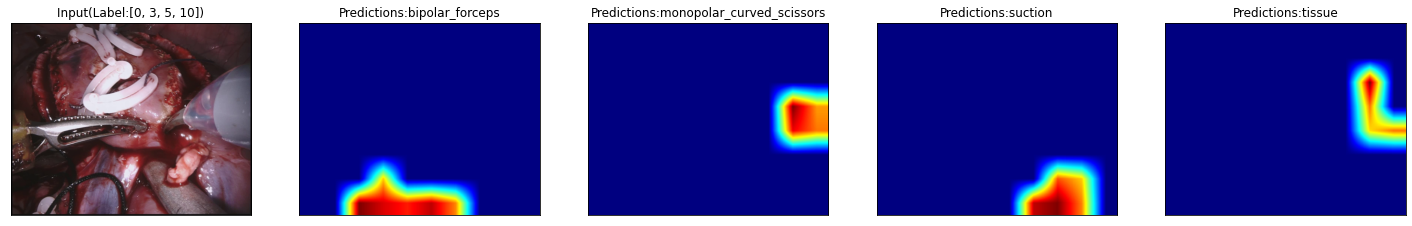

In [16]:
import torch.nn as nn
from torch.nn import DataParallel
from torchvision import models

def reg_hook_gradcam():
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    # register hooks for gradCAM model.layer4[-1].conv1
    #last_conv_layer = model.model.features.denseblock4.denselayer16.conv2
    #last_conv_layer = model.layer4[2].conv3
    last_conv_layer = model.layer4[-1].conv1
    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def get_gradcam(model, img, lab):
    reg_hook_gradcam()
    out = model(img).cpu()
    out = torch.sigmoid(out)
    true_labels = np.argwhere(lab.cpu()==1)[1]
    pred_labels = np.argwhere(out.cpu()>0.5)[1]
    print('Probability:',[round(pro.item(), 3) for pro in out.squeeze()])
    print('Labels:',[tl.item() for tl in true_labels],'Predictions:', [pl.item() for pl in pred_labels])
    pred_lab_each = []
    for ii in pred_labels:
        backward_arg = torch.zeros(1,11)
        backward_arg[0,ii] = 1
        pred_lab_each.append(backward_arg)

    #a = pred_lab_each[0]
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    supim_all = []
    heatmap_all = []
    for a in pred_lab_each:
        out.backward(a, retain_graph=True)
        gradients = stored_grads[0].clone()
        activations = stored_fpass[0].clone().unsqueeze(0)
        activations = activations.detach()

        pooled_gradients = torch.mean(gradients, dim=[2, 3])
        activations *= pooled_gradients[:,:,None, None]
        # for j in range(gradients.shape[1]):
        #     activations[:, j, :, :] *= pooled_gradients[j]

        print('pooled_gradients, activations, gradients:',pooled_gradients.shape, activations.shape, gradients.shape)
        heatmap = torch.sum(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        #print('min max', heatmap.min(), heatmap.max())
        hmap = heatmap.numpy()
        hmap[hmap<0.65] = 0
        heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
        heatmap1 = np.uint8(-255 * heatmap1 + 255)
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
        heatmap_all.append(heatmap1)
    return heatmap_all, pred_labels, true_labels

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 11)
model = DataParallel(model)
# model.to(device)
result_filename = 'combine_miccai18_ResNet50_256,320_170'
best_checkpoint_path = 'localization/' + result_filename + '_best_checkpoint.pth.tar'
checkpoint = torch.load(best_checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model = model.module
model.cuda();
model.eval()

image_name = "localization/1_frame146.png"   
classes = ['bipolar_forceps', 'prograsp_forceps', 'large_needle_driver', 'monopolar_curved_scissors', 'ultrasound_probe', 'suction', 'clip_applier', 'stapler', 'hook', 'specimen_bag', 'tissue']

'''------------------------------------- Load image ------------------------------------'''
image = Image.open(image_name).convert('RGB')
transforms = tf.Compose([tf.Resize((256,320)), 
                        tf.ToTensor(),
                        tf.Normalize([0.4084945, 0.25513682, 0.25353566], [0.22662906, 0.20201652, 0.1962526 ])])

img = transforms(image).cuda()
lab = torch.tensor([1,0,0,1,0,1,0,0,0,0,1])
img, lab = img[None], lab[None]
heatmap_all, pred_labels, true_labels = get_gradcam(model, img, lab)

num_img = len(heatmap_all)+1
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
#ax[0].imshow(img[0].detach().permute(1,2,0).cpu())
ax[0].imshow(image)
ax[0].set_title('Input(Label:{})'.format([tl.item() for tl in true_labels]))

for idx, heatmap in enumerate(heatmap_all):
    ax[idx+1].imshow(heatmap)
    ax[idx+1].set_title('Predictions:{}'.format([classes[pl.item()] for pl in pred_labels][idx]))


# Single Pass GradCAM++

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get th

Probability: [0.999, 0.33, 0.016, 0.873, 0.002, 0.996, 0.006, 0.054, 0.0, 0.0, 1.0]
Labels: [0, 3, 5, 10] Predictions: [0, 3, 5, 10]


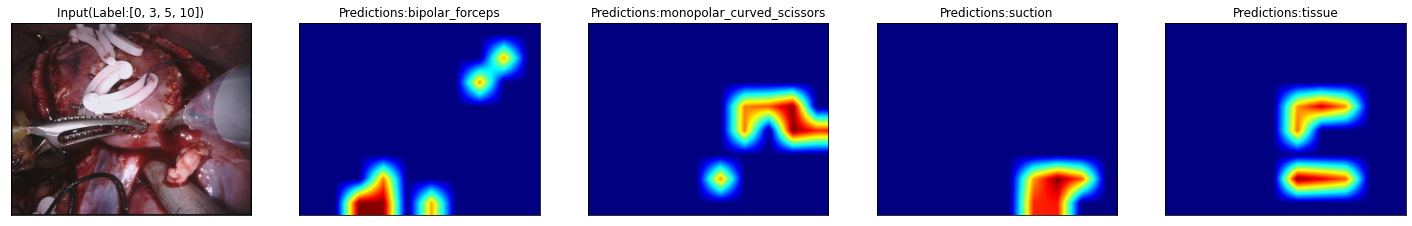

In [23]:
import torch.nn as nn
from torch.nn import DataParallel
from torchvision import models

def reg_hook_gradcam():
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    # register hooks for gradCAM model.layer4[-1].conv1
    #last_conv_layer = model.model.features.denseblock4.denselayer16.conv2
    #last_conv_layer = model.layer4[2].conv3
    last_conv_layer = model.layer4[-1].conv1
    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def gradcam_pp(grads, activations):
    grads_power_2 = grads**2
    grads_power_3 = grads_power_2 * grads
    # Equation 19 in https://arxiv.org/abs/1710.11063
    sum_activations = torch.sum(activations, dim=[ 2, 3])
    eps = 0.000001
    aij = grads_power_2 / (2 * grads_power_2 +
                            sum_activations[:, :, None, None] * grads_power_3 + eps)
    # Now bring back the ReLU from eq.7 in the paper,
    # And zero out aijs where the activations are 0
    aij = torch.where(grads != 0, aij, 0)

    weights = torch.maximum(grads, torch.tensor(0)) * aij
    weights = torch.sum(weights, dim=[ 2, 3])
    return weights

def get_gradcam(model, img, lab):
    reg_hook_gradcam()
    out = model(img).cpu()
    out = torch.sigmoid(out)
    true_labels = np.argwhere(lab.cpu()==1)[1]
    pred_labels = np.argwhere(out.cpu()>0.5)[1]
    print('Probability:',[round(pro.item(), 3) for pro in out.squeeze()])
    print('Labels:',[tl.item() for tl in true_labels],'Predictions:', [pl.item() for pl in pred_labels])
    pred_lab_each = []
    for ii in pred_labels:
        backward_arg = torch.zeros(1,11)
        backward_arg[0,ii] = 1
        pred_lab_each.append(backward_arg)

    #a = pred_lab_each[0]
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    supim_all = []
    heatmap_all = []
    for a in pred_lab_each:
        out.backward(a, retain_graph=True)
        gradients = stored_grads[0].clone()
        activations = stored_fpass[0].clone().unsqueeze(0)
        activations = activations.detach()

        #pooled_gradients = torch.mean(gradients, dim=[ 2, 3])
        pooled_gradients = gradcam_pp(gradients, activations)

        activations *= pooled_gradients[:,:,None, None]
        # for j in range(gradients.shape[1]):
        #     activations[:, j, :, :] *= pooled_gradients[j]

        heatmap = torch.sum(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        #print('min max', heatmap.min(), heatmap.max())
        hmap = heatmap.numpy()
        hmap[hmap<0.70] = 0
        heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
        heatmap1 = np.uint8(-255 * heatmap1 + 255)
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
        heatmap_all.append(heatmap1)
    return heatmap_all, pred_labels, true_labels

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 11)
model = DataParallel(model)
# model.to(device)
result_filename = 'combine_miccai18_ResNet50_256,320_170'
best_checkpoint_path = 'localization/' + result_filename + '_best_checkpoint.pth.tar'
checkpoint = torch.load(best_checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model = model.module
model.cuda();
model.eval()

image_name = "localization/1_frame146.png"   
classes = ['bipolar_forceps', 'prograsp_forceps', 'large_needle_driver', 'monopolar_curved_scissors', 'ultrasound_probe', 'suction', 'clip_applier', 'stapler', 'hook', 'specimen_bag', 'tissue']

'''------------------------------------- Load image ------------------------------------'''
image = Image.open(image_name).convert('RGB')
transforms = tf.Compose([tf.Resize((256,320)), 
                        tf.ToTensor(),
                        tf.Normalize([0.4084945, 0.25513682, 0.25353566], [0.22662906, 0.20201652, 0.1962526 ])])

img = transforms(image).cuda()
lab = torch.tensor([1,0,0,1,0,1,0,0,0,0,1])
img, lab = img[None], lab[None]
heatmap_all, pred_labels, true_labels = get_gradcam(model, img, lab)

num_img = len(heatmap_all)+1
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
#ax[0].imshow(img[0].detach().permute(1,2,0).cpu())
ax[0].imshow(image)
ax[0].set_title('Input(Label:{})'.format([tl.item() for tl in true_labels]))

for idx, heatmap in enumerate(heatmap_all):
    ax[idx+1].imshow(heatmap)
    ax[idx+1].set_title('Predictions:{}'.format([classes[pl.item()] for pl in pred_labels][idx]))
